In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime as dt

### Data Loading

In [73]:
players = pd.read_csv('Players.csv')
stats   = pd.read_csv('stats.csv', index_col = 0)
star = pd.read_excel('All Star.xlsx')

### Data Cleaning Part 1

In [74]:
### dropping the teams which are no longer in the NBA ###
charl_idx = star[star.Team == 'Charlotte Bobcats'].index     
seattle_idx = star[star.Team == 'Seattle SuperSonics'].index 
star.drop(index=charl_idx,inplace=True)
star.drop(index=seattle_idx,inplace=True)

In [75]:
### creating new columns for encoding new features ### 
star['Western'] = 0
star['Eastern'] = 0
star['Fan Vote'] = 0
star['Coaches'] = 0
star['Replacement'] = 0

In [76]:
### encoding selection type ###

wes_idx = star[star['Selection Type'].str.contains('Western')].index
eas_idx = star[star['Selection Type'].str.contains('Eastern')].index
fan_idx = star[star['Selection Type'].str.contains('Fan')].index
coache_idx = star[star['Selection Type'].str.contains('Coaches')].index
Rep_idx = star[star['Selection Type'].str.contains('Replacement')].index

star.loc[list(wes_idx),'Western'] = 1
star.loc[list(eas_idx),'Eastern'] = 1
star.loc[list(fan_idx),'Fan Vote'] = 1
star.loc[list(coache_idx),'Coaches'] = 1
star.loc[list(Rep_idx),'Replacement'] = 1

In [77]:
### encoding NBA Draft Status ###
star['Draft Year'] = [int(i[0:4]) for i in star['NBA Draft Status']] # get draft year

def draft(x):     # get overall draft order 
    l = x.split()
    if 'Undrafted' in x:
        return None
    elif l[2] == '1':
        return l[4]
    else :
        return int(l[4]) + 30
    
star['Draft Order'] = star['NBA Draft Status'].apply(draft)

In [78]:
### dealing with the problem of having two nationalities ###
for idx, nat in enumerate(star['Nationality']):
    if '\n' in nat:
        l = nat.split('\n')
        star.loc[idx, 'First Nationality'] = l[0]
        star.loc[idx, 'Second Nationality'] = l[1]
    else :
        star.loc[idx, 'First Nationality'] = nat
        star.loc[idx, 'Second Nationality'] = None

In [79]:
star.dropna(thresh=6, inplace=True) # drop the missing values 

In [80]:
star.sample(5)

,Year,Player,Pos,HT,WT,Team,Selection Type,NBA Draft Status,Nationality,Western,Eastern,Fan Vote,Coaches,Replacement,Draft Year,Draft Order,First Nationality,Second Nationality
134,2011.0,Roy Hibbert,C,2017-07-02 00:00:00,270.0,Indiana Pacers,Eastern All-Star Coaches Selection,2008 Rnd 1 Pick 17,United States,0.0,1.0,0.0,1.0,0.0,2008.0,17,United States,None
181,2009.0,Kevin Durant,SF,2017-06-09 00:00:00,240.0,Oklahoma City Thunder,Western All-Star Coaches Selection,2007 Rnd 1 Pick 2,United States,1.0,0.0,0.0,1.0,0.0,2007.0,2,United States,None
129,2011.0,Dwyane Wade,SG,2017-06-04 00:00:00,220.0,Miami Heat,Eastern All-Star Fan Vote Selection,2003 Rnd 1 Pick 5,United States,0.0,1.0,1.0,0.0,0.0,2003.0,5,United States,None
310,2005.0,Rasheed Wallace,FC,2017-06-11 00:00:00,230.0,Detroit Pistons,Eastern All-Star Coaches Selection,1995 Rnd 1 Pick 4,United States,0.0,1.0,0.0,1.0,0.0,1995.0,4,United States,None
197,2009.0,Dwight Howard,C,2017-06-11 00:00:00,265.0,Orlando Magic,Eastern All-Star Fan Vote Selection,2004 Rnd 1 Pick 1,United States,0.0,1.0,1.0,0.0,0.0,2004.0,1,United States,None


In [81]:
## the column HT is the height of All star players, but it's quite messy, containing two data types: string and datetime, 
## so we need to do some conversion.

def height_convert(x):
    if type(x) != str:
        feet = float(x.strftime('%D')[1])
        inches = float(x.strftime('%D')[3:5])
        height = feet*12 + inches 
    else:
        height = float(x[0])*12
    return height

star['HT_inches'] = star['HT'].apply(height_convert) # the new column Height is player's height in inches. 
star['HT_cm'] = star['HT_inches']*2.54

In [82]:
## There are many players playing different positions, and the combination of different positions 
## makes it difficult to conduct analysis, therefore a function to sort players by their 
## primary positions is created.
def position_sorter (df):
    df.loc[df['Pos']=='C-PF','Pos']='C'
    df.loc[df['Pos']=='C-SF','Pos']='C'
    df.loc[df['Pos']=='FC','Pos']='PF'
    df.loc[df['Pos']=='F','Pos']='PF'
    df.loc[df['Pos']=='F-C','Pos']='PF'
    df.loc[df['Pos']=='G','Pos']='PG'
    df.loc[df['Pos']=='G-F','Pos']='PG'
    df.loc[df['Pos']=='PF-C','Pos']='PF'
    df.loc[df['Pos']=='PF-SF','Pos']='PF'
    df.loc[df['Pos']=='PG-SF','Pos']='PG'
    df.loc[df['Pos']=='PG-SG','Pos']='PG'
    df.loc[df['Pos']=='SF-PF','Pos']='SF'
    df.loc[df['Pos']=='SF-SG','Pos']='SF'
    df.loc[df['Pos']=='SG-PF','Pos']='SG'
    df.loc[df['Pos']=='SG-PG','Pos']='SG'
    df.loc[df['Pos']=='SG-SF','Pos']='SG'
    df.loc[df['Pos']=='GF','Pos']='SG'
    
    return df

In [83]:
## limit all data to the period between 2000 to 2016
stats = stats[stats['Year']>=2000 &(stats['Year']<=2016)]


In [84]:
## get weight and height data for all players in NBA ## 
players_stats = pd.merge(left=players, right=stats, on='Player', how = 'inner', indicator=True)
players_stats['weight_lb'] = players_stats['weight']*2.205    # convert kg to lb in a new column 

players_height_weight = players_stats[['Pos','Player' ,'height','weight_lb']]
players_height_weight = players_height_weight.drop_duplicates(subset='Player')
players_height_weight.reset_index(inplace=True)
players_height_weight.drop(columns='index',inplace=True)

## Use position sorter function to change play positions to their primary positions

players_height_weight = position_sorter(players_height_weight)
star = position_sorter(star)

## table comparing body build for All-Star players and all players in NBA ## 
all_players_build = players_height_weight.groupby('Pos').mean()
star_players_build = star.groupby(by=['Pos']).mean()[['HT_cm','WT']]
build_compare = pd.merge(left = star_players_build, right=all_players_build, on='Pos', how='left', indicator=True)
build_compare.rename(columns={'HT_cm':'height_star', 'WT':'weight_star', 'height':'height_all', 'weight_lb': 'weight_all'}, inplace=True)

In [85]:
build_compare.drop(columns='_merge', inplace=True)
build_compare

,height_star,weight_star,height_all,weight_all
Pos,,,,
C,216.204800,279.260000,209.949853,239.681549
PF,208.063171,243.628049,203.275449,222.007850
PG,189.086226,191.971698,187.696855,182.937340
SF,201.385714,231.228571,200.115789,209.486605
SG,198.763467,216.626667,194.286765,195.693750


### Data Cleaning Part 2

In [86]:
## compare stats between All star players and regular players in different dimensions
## first get All-star player stats 
Allstar_stats = pd.merge(star, stats,on=['Year','Player'], how='left')
Allstar_stats.rename(columns={'Pos_x':'Pos'}, inplace = True)

## Noticed that some players exists in mulitiple teams in a single season as a result of trading, 
## Therefore need to remove duplicates and keep the one row that shows the season end cumulative stats
Allstar_stats = Allstar_stats.sort_values('PTS', ascending=False).drop_duplicates(subset=['Year', 'Player'])

## Get regular players' stats between 2000-2016 (to match our All-star player list period)

reg_stats = stats[(~stats['Player'].isin(star['Player'])) & (stats['Year']>=2000) &(stats['Year']<=2016)]
reg_stats = reg_stats.sort_values('PTS', ascending=False).drop_duplicates(subset=['Year', 'Player'])

In [87]:
## screen through all stats preliminarily and note columns that are considerably different or representative
Allstar_stats.describe()
reg_stats.describe()

## Select columns that may be relevant to our study such as points per game, number of games played, minutes played
## player efficiency rating, field goal percentage, number of assists, personal fouls, and points.
columns_to_keep = ['Year','Player','Pos','Age','G','MP','PER','FG%','AST','PF','PTS']
Allstar_stats = Allstar_stats[columns_to_keep]
reg_stats = reg_stats[columns_to_keep]

In [88]:
## Use position sorter function to change play positions to their primary positions
Allstar_stats = position_sorter(Allstar_stats)
reg_stats = position_sorter(reg_stats)

##  Group player stats by positions 
reg_avg = reg_stats.groupby('Pos').mean()
allstar_avg = Allstar_stats.groupby('Pos').mean()

## Create dataframe to compare selected coluns between All-star players and regular players
stats_table = pd.merge(allstar_avg, reg_avg, on='Pos', how='left')

## Clean up the table 
stats_table.drop(columns=['Year_x','Year_y'],inplace= True)
stats_table.columns=['star_age','star_games','star_minutes','star_efficiency','star_field_goal%','star_assists','star_fouls','star_points',
                    'reg_age','reg_games','reg_minutes','reg_efficiency','reg_field_goal%','reg_assists','reg_fouls','reg_points']
stats_table = stats_table.transpose()

In [89]:
stats_table

Pos,C,PF,PG,SF,SG
star_age,25.206897,26.267081,25.510417,26.303030,26.534247
star_games,68.482759,71.559006,73.364583,71.727273,69.849315
star_minutes,2230.034483,2576.832298,2613.822917,2691.636364,2596.123288
star_efficiency,20.289655,22.137888,20.885417,21.681818,21.094521
star_field_goal%,0.528483,0.489621,0.455688,0.460273,0.451781
star_assists,127.827586,226.527950,548.322917,281.575758,331.219178
star_fouls,222.103448,185.695652,164.281250,184.272727,164.616438
star_points,1085.931034,1451.155280,1376.125000,1688.393939,1586.232877
reg_age,26.930216,26.639613,26.995283,26.512571,26.384443
reg_games,49.332374,51.501117,52.194182,52.663423,53.157068


### Data Visualization

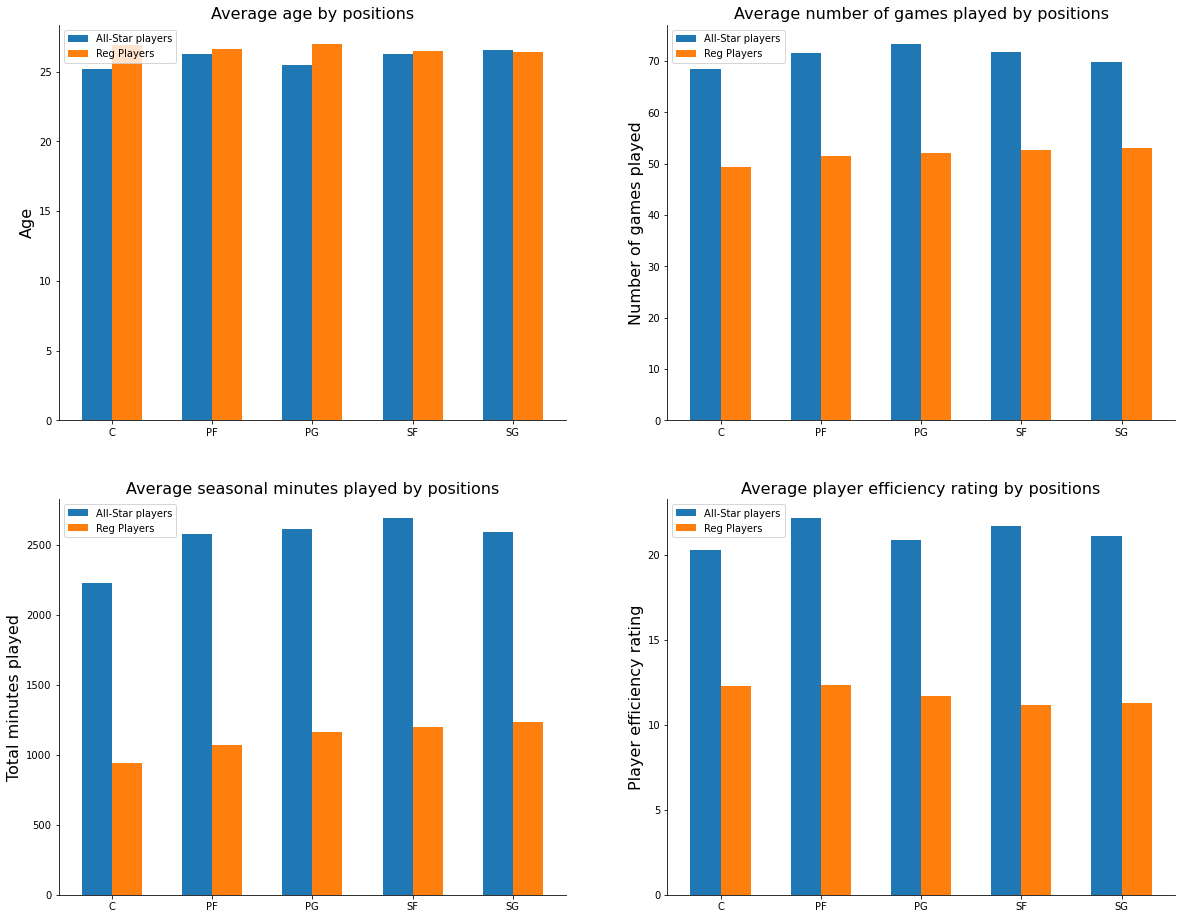

In [91]:
## Subplots comparision on age, number of games played, total minutes played, 
## and player efficiency rating
x = np.arange(5)

fig, ax = plt.subplots(2,2,figsize = (20,16))


ax[0][0].bar(x-0.15, stats_table.loc['star_age',:], width = 0.3, label='All-Star players')
ax[0][0].bar(x+0.15, stats_table.loc['reg_age',:], width = 0.3, label='Reg Players')
ax[0][0].set_ylabel('Age',fontsize=16)
ax[0][0].set_title('Average age by positions',fontsize=16)
plt.sca(ax[0, 0])
plt.xticks(x, ['C','PF','PG','SF','SG'])
ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].legend()

ax[0][1].bar(x-0.15, stats_table.loc['star_games',:], width = 0.3, label='All-Star players')
ax[0][1].bar(x+0.15, stats_table.loc['reg_games',:], width = 0.3, label='Reg Players')
ax[0][1].set_ylabel('Number of games played',fontsize=16)
ax[0][1].set_title('Average number of games played by positions',fontsize=16)
plt.sca(ax[0, 1])
plt.xticks(x, ['C','PF','PG','SF','SG'])
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].legend()


ax[1][0].bar(x-0.15, stats_table.loc['star_minutes',:], width = 0.3, label='All-Star players')
ax[1][0].bar(x+0.15, stats_table.loc['reg_minutes',:], width = 0.3, label='Reg Players')
ax[1][0].set_ylabel('Total minutes played',fontsize=16)
ax[1][0].set_title('Average seasonal minutes played by positions',fontsize=16)
plt.sca(ax[1, 0])
plt.xticks(x, ['C','PF','PG','SF','SG'])
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].legend()

ax[1][1].bar(x-0.15, stats_table.loc['star_efficiency',:], width = 0.3, label='All-Star players')
ax[1][1].bar(x+0.15, stats_table.loc['reg_efficiency',:], width = 0.3, label='Reg Players')
ax[1][1].set_ylabel('Player efficiency rating',fontsize=16)
ax[1][1].set_title('Average player efficiency rating by positions',fontsize=16)
plt.sca(ax[1, 1])
plt.xticks(x, ['C','PF','PG','SF','SG'])
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].legend()

plt.show()

In [92]:
range(3)

range(0, 3)

In [93]:
np.arange(5)

array([0, 1, 2, 3, 4])

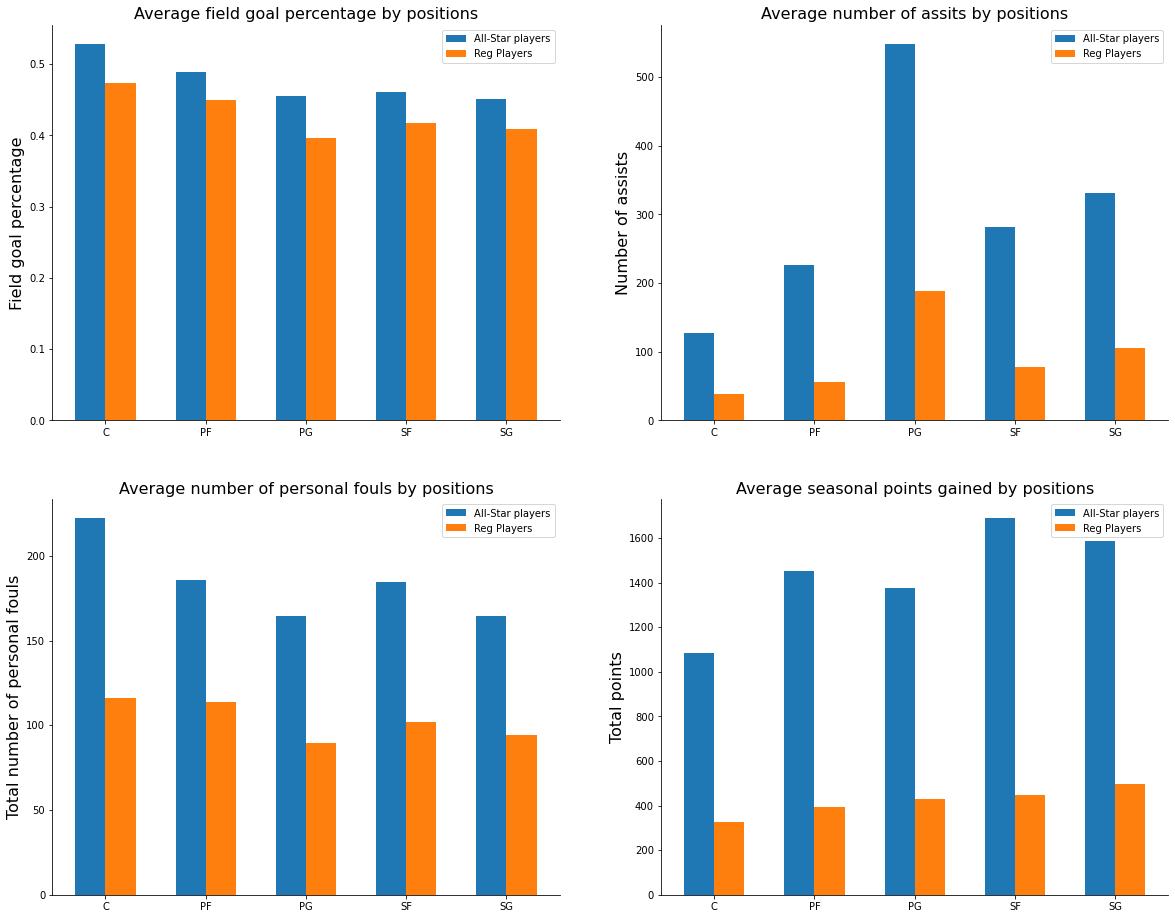

In [95]:
## Subplots comparision on field goal percentage, number of assists, personal fouls, and points.

fig, ax = plt.subplots(2,2,figsize = (20,16))
x = np.arange(5)


ax[0][0].bar(x-0.15, stats_table.loc['star_field_goal%',:], width = 0.3,   label='All-Star players')
ax[0][0].bar(x+0.15, stats_table.loc['reg_field_goal%',:], width = 0.3,  label='Reg Players')
ax[0][0].set_ylabel('Field goal percentage',fontsize=16)
ax[0][0].set_title('Average field goal percentage by positions',fontsize=16)
plt.sca(ax[0, 0])
plt.xticks(x, ['C','PF','PG','SF','SG'])
#ax[0][0].set_xticklabels(['0','C','PF','PG','SF','SG'])
ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].legend()

ax[0][1].bar(x-0.15, stats_table.loc['star_assists',:], width = 0.3,   label='All-Star players')
ax[0][1].bar(x+0.15, stats_table.loc['reg_assists',:], width = 0.3,  label='Reg Players')
ax[0][1].set_ylabel('Number of assists',fontsize=16)
ax[0][1].set_title('Average number of assits by positions',fontsize=16)
plt.sca(ax[0, 1])
plt.xticks(x, ['C','PF','PG','SF','SG'])
#ax[0][1].set_xticklabels(['0','C','PF','PG','SF','SG'])
ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].legend()

ax[1][0].bar(x-0.15, stats_table.loc['star_fouls',:], width = 0.3,   label='All-Star players')
ax[1][0].bar(x+0.15, stats_table.loc['reg_fouls',:], width = 0.3,  label='Reg Players')
ax[1][0].set_ylabel('Total number of personal fouls',fontsize=16)
ax[1][0].set_title('Average number of personal fouls by positions',fontsize=16)
plt.sca(ax[1, 0])
plt.xticks(x, ['C','PF','PG','SF','SG'])
#ax[1][0].set_xticklabels(['0','C','PF','PG','SF','SG'])
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].legend()

ax[1][1].bar(x-0.15, stats_table.loc['star_points',:], width = 0.3,   label='All-Star players')
ax[1][1].bar(x+0.15, stats_table.loc['reg_points',:], width = 0.3,  label='Reg Players')
ax[1][1].set_ylabel('Total points',fontsize=16)
ax[1][1].set_title('Average seasonal points gained by positions',fontsize=16)
plt.sca(ax[1, 1])
plt.xticks(x, ['C','PF','PG','SF','SG'])
#ax[1][1].set_xticklabels(['0','C','PF','PG','SF','SG'])
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].legend()

plt.show()

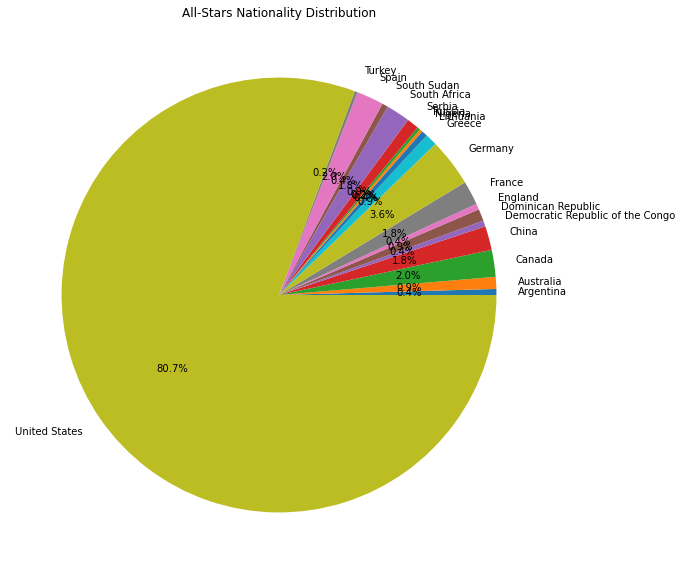

In [96]:
nat_counts = star[['First Nationality', 'Second Nationality']].apply(pd.value_counts)
labels = nat_counts.index
nat_counts = nat_counts.fillna(0)
values = nat_counts['First Nationality'] + nat_counts['Second Nationality']
countries = list(values.index)
countries_count = [i for i in values]

fig, ax = plt.subplots(figsize = (10,10))

ax.pie(countries_count, labels=countries, autopct='%1.1f%%')
ax.set_title('All-Stars Nationality Distribution')

sns.despine(ax=ax)

plt.show()

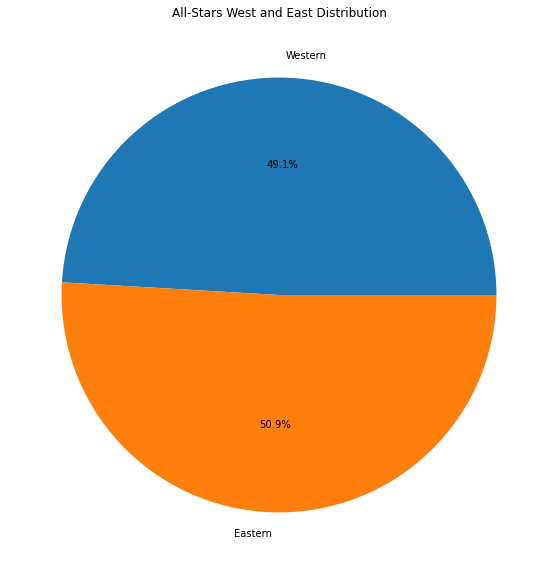

In [97]:
western_count = star['Western'].value_counts()[1]
eastern_count = star['Eastern'].value_counts()[1]
area_count = [western_count,eastern_count]
area = ['Western','Eastern']

fig, ax = plt.subplots(figsize = (10,10))

ax.pie(area_count, labels=area, autopct='%1.1f%%')
ax.set_title('All-Stars West and East Distribution')

sns.despine(ax=ax)

plt.show()

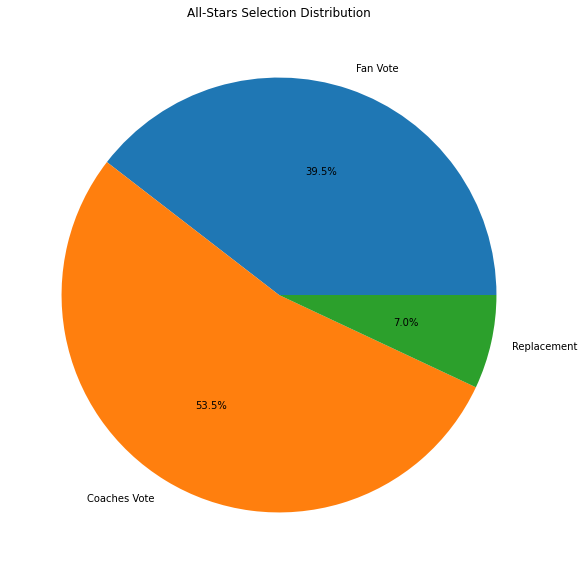

In [98]:
fan_vote = star['Fan Vote'].value_counts()[1]
coaches_vote = star['Coaches'].value_counts()[1]
replacement = star['Replacement'].value_counts()[1]
sel_count = [fan_vote,coaches_vote,replacement]
sel_type = ['Fan Vote','Coaches Vote','Replacement']


fig, ax = plt.subplots(figsize = (10,10))

ax.pie(sel_count, labels=sel_type, autopct='%1.1f%%')
ax.set_title('All-Stars Selection Distribution')

sns.despine(ax=ax)

plt.show()

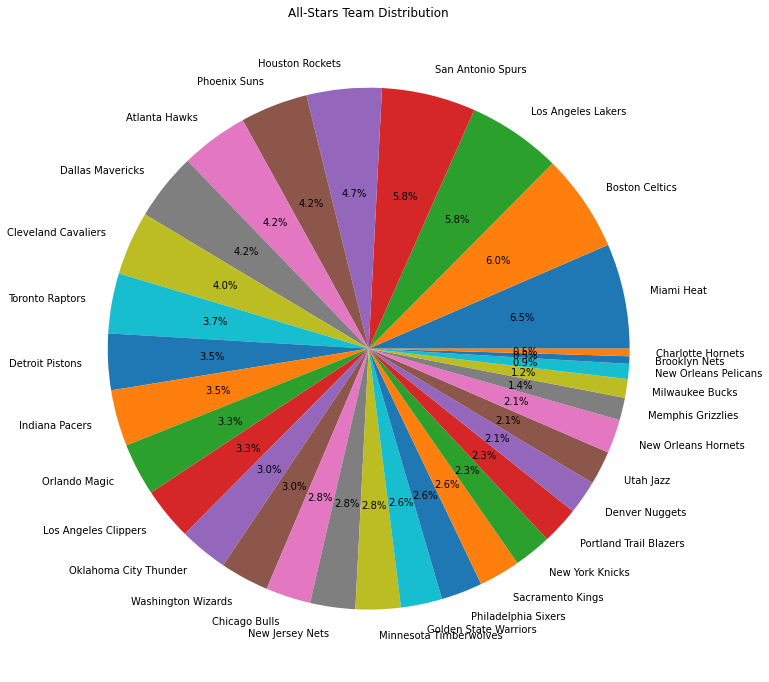

In [99]:
teams = star.Team.value_counts().index
teams_count = star.Team.value_counts()

fig, ax = plt.subplots(figsize = (12,12))

ax.pie(teams_count, labels=teams, autopct='%1.1f%%')
ax.set_title('All-Stars Team Distribution')

sns.despine(ax=ax)

plt.show()

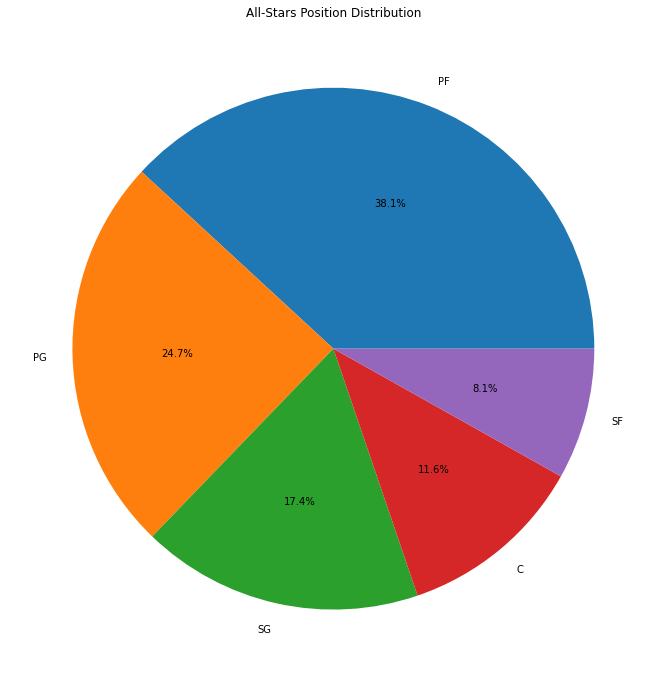

In [100]:
fig, ax = plt.subplots(figsize = (12,12))

ax.pie(star.Pos.value_counts(), labels=star.Pos.value_counts().index , autopct='%1.1f%%')
ax.set_title('All-Stars Position Distribution')

sns.despine(ax=ax)

plt.show()

In [101]:
build_compare

,height_star,weight_star,height_all,weight_all
Pos,,,,
C,216.204800,279.260000,209.949853,239.681549
PF,208.063171,243.628049,203.275449,222.007850
PG,189.086226,191.971698,187.696855,182.937340
SF,201.385714,231.228571,200.115789,209.486605
SG,198.763467,216.626667,194.286765,195.693750


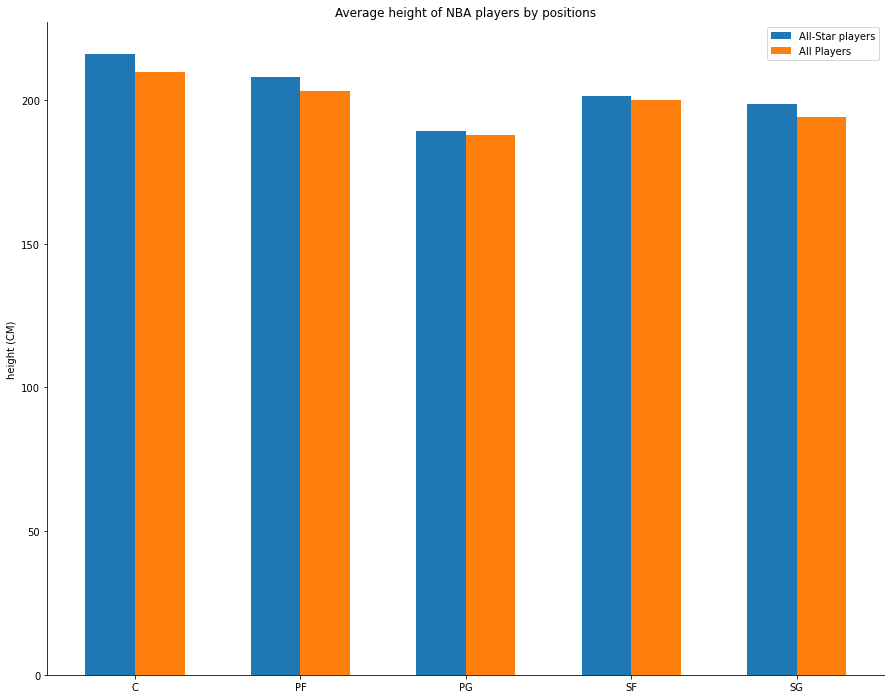

In [102]:
### comparing the average height of all-star players and all players ### 

fig, ax = plt.subplots(figsize = (15,12))

x = np.arange(5)

ax.bar(x-0.15, build_compare.height_star, width = 0.3,   label='All-Star players')
ax.bar(x+0.15, build_compare.height_all, width = 0.3,  label='All Players')
ax.set_ylabel('height (CM)')
ax.set_title('Average height of NBA players by positions')

plt.xticks(x,['C','PF','PG','SF','SG'])


ax.legend()


sns.despine(ax=ax)

plt.show()

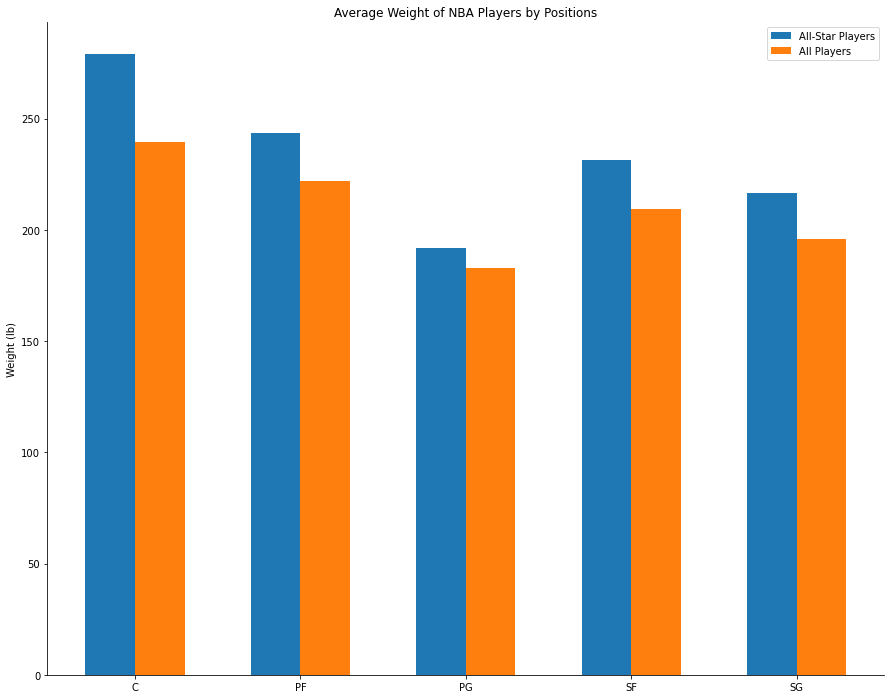

In [103]:
### comparing the weight of all-star players and all players ### 

fig, ax = plt.subplots(figsize = (15,12))

x = np.arange(5)

ax.bar(x-0.15, build_compare.weight_star, width = 0.3,   label='All-Star Players')
ax.bar(x+0.15, build_compare.weight_all, width = 0.3,  label='All Players')
ax.set_ylabel('Weight (lb)')
ax.set_title('Average Weight of NBA Players by Positions')

plt.xticks(x,['C','PF','PG','SF','SG'])

ax.legend()


sns.despine(ax=ax)

plt.show()